# MLP
Like MLP_207 with K=5 and epochs=200.

Use GMM for threshold.

In [29]:
from datetime import datetime
print(datetime.now())

2023-03-29 22:52:06.452729


In [30]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
print(DATA_DIR)

GPU device not found
Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [31]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=5
ALPHABET=4**K + 1
CFILTERS=64 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=200 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'RCI_GMM'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
EXCLUSIONS = set([0,2,3,4,5,6,7,8,9,10,11,12,13,14,15])   # only H1.hESC
FILTER_TAILS_TRAIN  = False
FILTER_TAILS_TEST   = False
FILTER_MIDDLE_TRAIN = False
FILTER_MIDDLE_TEST  = False
FILTER_NONE         = True

Python 3.9.16
sklearn 1.2.2


In [32]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.csv'
RCI_FILE_VALID = 'train.lncRNA_RCI.csv'
RCI_FILE_TEST  = None # else 'test.lncRNA_RCI.csv'

SEQ_FILE_TRAIN = 'train.all_lncRNA_transcripts.csv'
SEQ_FILE_VALID = 'train.all_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None # else 'test.canon_lncRNA_transcripts.csv'

In [33]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [34]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    log_mean=0.0
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = [2**x for x in values]
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = -1000000 # neg infinity
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
                    # TO DO: get rid of this check on our log/antilog arithmetic.
                    if len(rci_values)==1:
                        diff = rci_values[0]-log_mean
                        if diff>0.000001:
                            print('antilog',log_mean,'not equal',rci_values,'for gene',gene_id)
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        if seq_len<=MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                        seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

    def load_spectra(self,filepath):
        '''
        Load all (variable-length) sequences as lists of kmers.
        Then convert each sequence to (fixed-length) kmer histograms.
        '''
        allids,allseq = self.load_sequence(filepath)
        allspectra = []
        for seq in allseq:
            spectrum = np.zeros(ALPHABET)
            for kmer in seq:
                spectrum[kmer] += 1
            spectrum /= len(seq)
            allspectra.append(spectrum)
        return allids,allspectra        


## Model

In [35]:
def build_model():
    mlp    = Sequential()
    layer1 = Dense(64, activation='sigmoid',dtype=dt,input_dim=ALPHABET)
    layer2 = Dense(64, activation='sigmoid')
    layer3 = Dense(64, activation='sigmoid')
    output = Dense(1, activation='sigmoid')
    mlp.add(layer1)
    mlp.add(layer2)
    mlp.add(layer3)
    mlp.add(output)
      
    bc=BinaryCrossentropy(from_logits=False)
    mlp.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return mlp

In [36]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-03-29 22:52:07.786460
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_88 (Dense)            (None, 64)                65664     
                                                                 
 dense_89 (Dense)            (None, 64)                4160      
                                                                 
 dense_90 (Dense)            (None, 64)                4160      
                                                                 
 dense_91 (Dense)            (None, 1)                 65        
                                                                 
Total params: 74,049
Trainable params: 74,049
Non-trainable params: 0
_________________________________________________________________
None


## Training

In [37]:
import gc
class CrossValidator():
    def __init__(self,epochs,quick_test=False,score_threshold=0.5):
        self.epochs = epochs
        self.quick_test = quick_test
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map, exclude_middle=False): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            if exclude_middle and oneY >= -2 and oneY <= 0:
                # Exclude middle from train set only, for comparison to Yuan et al
                continue
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        cw = class_weight.compute_class_weight(
            'balanced', classes=[0,1], y=y_train)
        cwd = {0: cw[0], 1: cw[1]}
        print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd) # no validation
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd, 
            validation_data=(X_valid,y_valid) ) 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)
        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [38]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            in_middle = gene_to_rci[gene_id] >= -2 and gene_to_rci[gene_id] <= 0
            in_tails = gene_to_rci[gene_id] < -2 or gene_to_rci[gene_id] > 0
            if gene_id in self.val_genes:
                if FILTER_NONE or \
                    (FILTER_TAILS_TEST and in_middle) or \
                    (FILTER_MIDDLE_TEST and in_tails):
                    self.val_ids.append(allids[t])
                    self.val_seq.append(allseq[t])
                    self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                if FILTER_NONE or \
                    (FILTER_TAILS_TRAIN and in_middle) or \
                    (FILTER_MIDDLE_TRAIN and in_tails):
                    self.train_ids.append(allids[t])
                    self.train_seq.append(allseq[t])
                    self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-03-29 22:52:07.996619
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 3774
Num RCI: 3774
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.all_lncRNA_transcripts.csv
Loaded 16957 sequences.
2023-03-29 22:53:23.441479

Training # 1 1
2023-03-29 22:53:23.442836
2023-03-29 22:53:23.442925
Discriminator is GMM
Means [0.26057748162210287, -1.0001829337407648]
Variances [1.49061749 1.45501972]
Priors [0.52147807 0.47852193]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
Train 1:0 7384:6317 53.89%
Computed class weights: {0: 1.084454646192813, 1: 0.9277491874322861}
Valid 1:0 2021:1235 62.07%
FIT
2023-03-29 22:53:36.853317


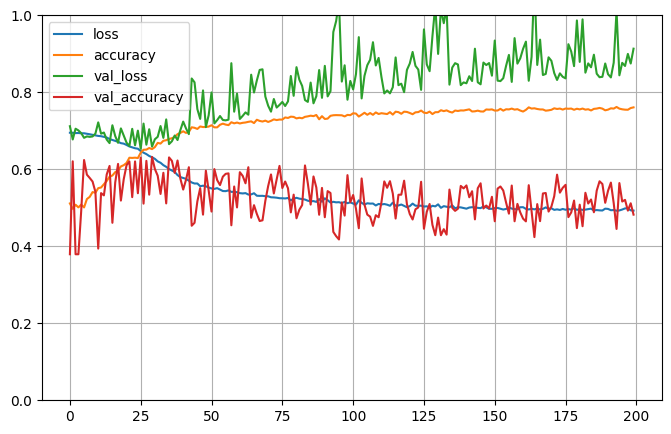


2023-03-29 22:59:35.444345

Testing # 1 1
2023-03-29 22:59:35.444455
2023-03-29 22:59:35.444503
PREDICT
2023-03-29 22:59:35.470467
Test 1:0 2021:1235 62.07%
Predict 1:0 1397:1859 42.91%
Test sizes (3256, 1025) (3256,)
Range of scores: 0.00017578145 to 0.9999017
Score threshold 0.5
Confusion matrix
 [[ 704  531]
 [1155  866]]
Normalized matrix
 [[0.21621622 0.16308354]
 [0.35472973 0.26597052]]


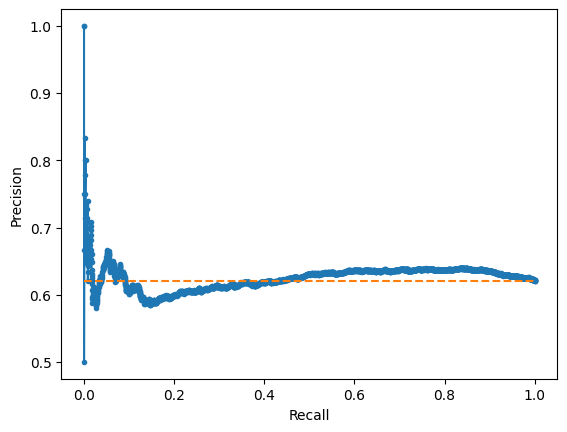

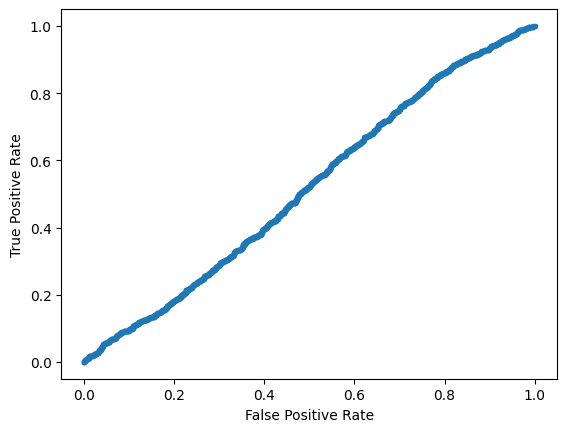

Accuracy: 48.22% Precision: 61.99% Recall: 42.85%
F1: 50.67% MCC: -0.0014
AUPRC: 62.53% AUROC: 51.76%
 accuracy [48.21867321867322]
 precision [61.989978525411594]
 recall [42.850074220682835]
 F1 [50.672908133411354]
 MCC [-0.0014300991398505474]
 AUPRC [62.53109885934409]
 AUROC [51.763487430562094]
2023-03-29 22:59:36.306930

Training # 1 2
2023-03-29 22:59:36.307623
2023-03-29 22:59:36.307692
Discriminator is GMM
Means [-1.0881417206952089, 0.35783479100482685]
Variances [1.48214915 1.47574834]
Priors [0.44018654 0.55981346]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
Train 1:0 8154:5404 60.14%
Computed class weights: {0: 1.254441154700222, 1: 0.8313711062055433}
Valid 1:0 1954:1445 57.49%
FIT
2023-03-29 22:59:49.100494


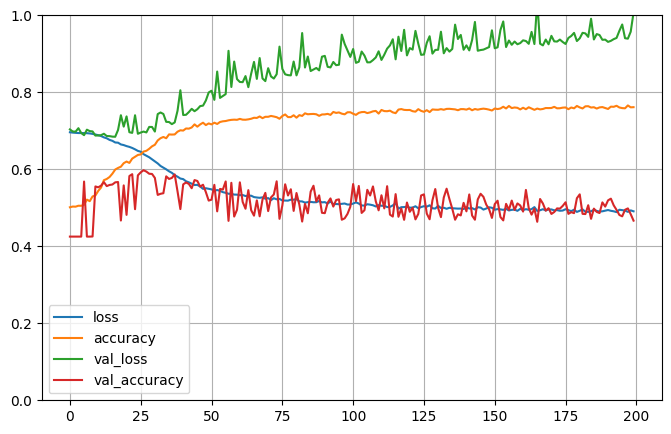


2023-03-29 23:06:12.991631

Testing # 1 2
2023-03-29 23:06:12.993352
2023-03-29 23:06:12.993773
PREDICT
2023-03-29 23:06:13.034397
Test 1:0 1954:1445 57.49%
Predict 1:0 1241:2158 36.51%
Test sizes (3399, 1025) (3399,)
Range of scores: 2.5993324e-07 to 0.9999446
Score threshold 0.5
Confusion matrix
 [[ 895  550]
 [1263  691]]
Normalized matrix
 [[0.26331274 0.1618123 ]
 [0.37157988 0.20329509]]


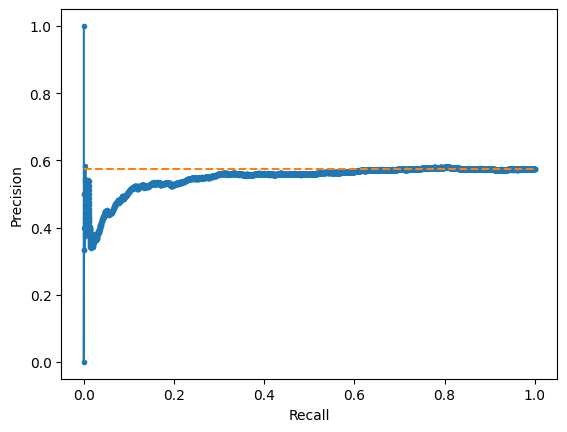

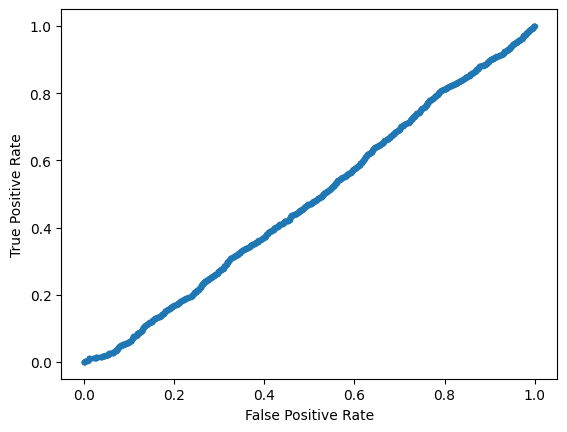

Accuracy: 46.66% Precision: 55.68% Recall: 35.36%
F1: 43.26% MCC: -0.0277
AUPRC: 54.88% AUROC: 48.13%
 accuracy [46.66078258311268]
 precision [55.6809024979855]
 recall [35.36335721596725]
 F1 [43.255086071987485]
 MCC [-0.027712496626659654]
 AUPRC [54.87666155474331]
 AUROC [48.1345160136425]
2023-03-29 23:06:14.371254

Training # 1 3
2023-03-29 23:06:14.372427
2023-03-29 23:06:14.372498
Discriminator is GMM
Means [0.283680699807134, -1.1467676695570388]
Variances [1.458219 1.492801]
Priors [0.59105958 0.40894042]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
Train 1:0 9124:4817 65.45%
Computed class weights: {0: 1.4470624870251194, 1: 0.7639741341516879}
Valid 1:0 2047:969 67.87%
FIT
2023-03-29 23:06:25.594954


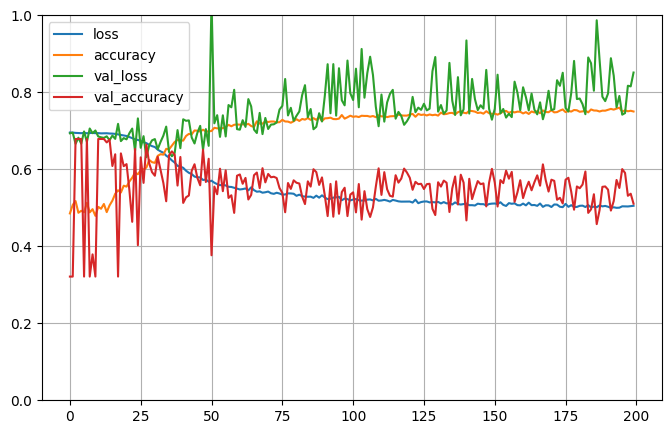


2023-03-29 23:12:00.583904

Testing # 1 3
2023-03-29 23:12:00.584032
2023-03-29 23:12:00.584086
PREDICT
2023-03-29 23:12:00.613133
Test 1:0 2047:969 67.87%
Predict 1:0 1319:1697 43.73%
Test sizes (3016, 1025) (3016,)
Range of scores: 0.0009102377 to 0.99958175
Score threshold 0.5
Confusion matrix
 [[ 595  374]
 [1102  945]]
Normalized matrix
 [[0.19728117 0.12400531]
 [0.36538462 0.31332891]]


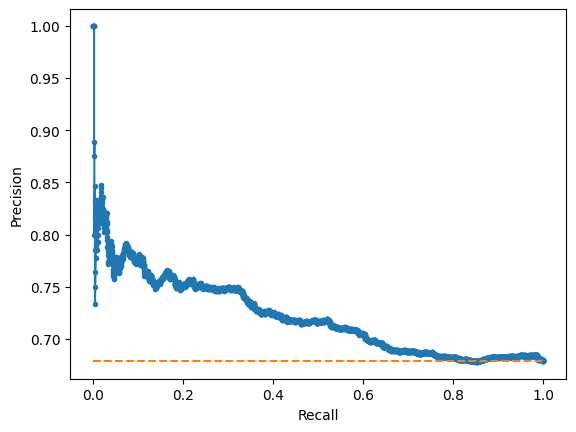

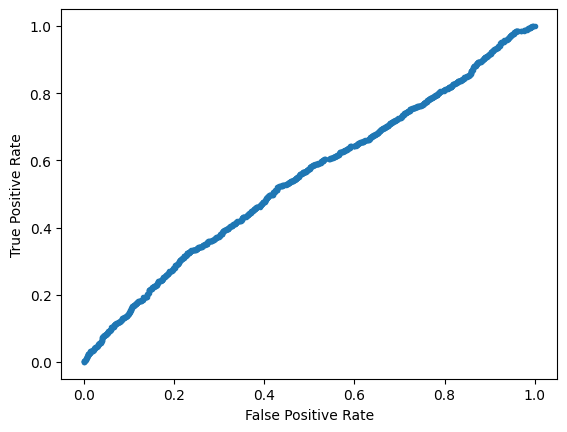

Accuracy: 51.06% Precision: 71.65% Recall: 46.17%
F1: 56.15% MCC: 0.0712
AUPRC: 72.14% AUROC: 54.73%
 accuracy [51.06100795755968]
 precision [71.64518574677786]
 recall [46.16511968734734]
 F1 [56.14973262032086]
 MCC [0.07124832803908757]
 AUPRC [72.14063173339436]
 AUROC [54.72576092376117]
2023-03-29 23:12:01.605868

Training # 1 4
2023-03-29 23:12:01.607857
2023-03-29 23:12:01.608685
Discriminator is GMM
Means [0.2834561797710331, -1.0812125912945043]
Variances [1.26605649 1.49296121]
Priors [0.55332764 0.44667236]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
Train 1:0 8570:5153 62.45%
Computed class weights: {0: 1.3315544343101107, 1: 0.8006417736289382}
Valid 1:0 1872:1362 57.88%
FIT
2023-03-29 23:12:14.749619


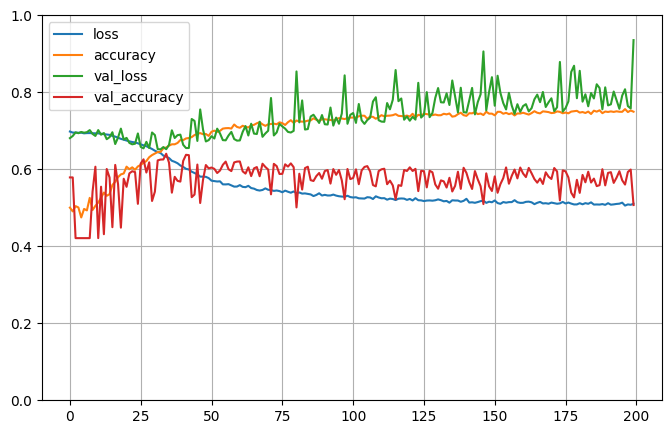


2023-03-29 23:17:52.495567

Testing # 1 4
2023-03-29 23:17:52.496423
2023-03-29 23:17:52.496477
PREDICT
2023-03-29 23:17:52.522890
Test 1:0 1872:1362 57.88%
Predict 1:0 736:2498 22.76%
Test sizes (3234, 1025) (3234,)
Range of scores: 1.3323773e-05 to 0.99879754
Score threshold 0.5
Confusion matrix
 [[1133  229]
 [1365  507]]
Normalized matrix
 [[0.35034014 0.07081014]
 [0.42207792 0.1567718 ]]


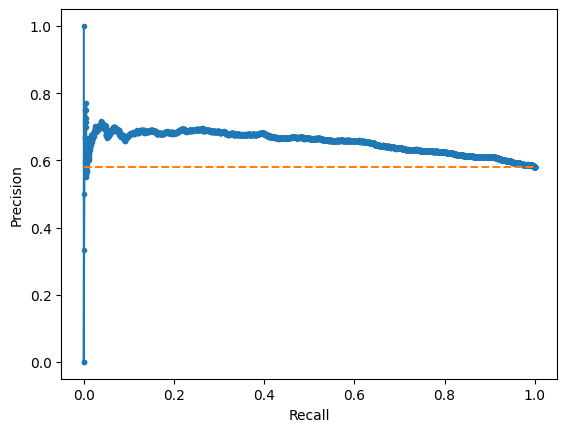

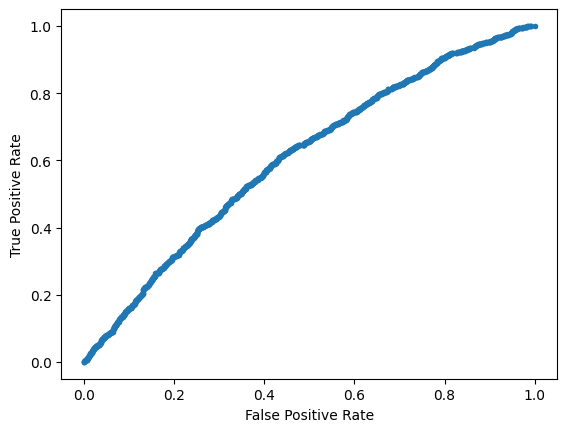

Accuracy: 50.71% Precision: 68.89% Recall: 27.08%
F1: 38.88% MCC: 0.1209
AUPRC: 65.40% AUROC: 60.77%
 accuracy [50.71119356833642]
 precision [68.88586956521739]
 recall [27.083333333333332]
 F1 [38.88036809815951]
 MCC [0.12093982720419585]
 AUPRC [65.40028367273267]
 AUROC [60.76847772883015]
2023-03-29 23:17:53.470767

Training # 1 5
2023-03-29 23:17:53.471997
2023-03-29 23:17:53.472069
Discriminator is GMM
Means [-0.7621516474991559, 0.6944897911872999]
Variances [1.47152103 1.67052425]
Priors [0.67883184 0.32116816]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
Train 1:0 2624:10281 20.33%
Computed class weights: {0: 0.6276140453263301, 1: 2.459032012195122}
Valid 1:0 921:3131 22.73%
FIT
2023-03-29 23:18:05.878585


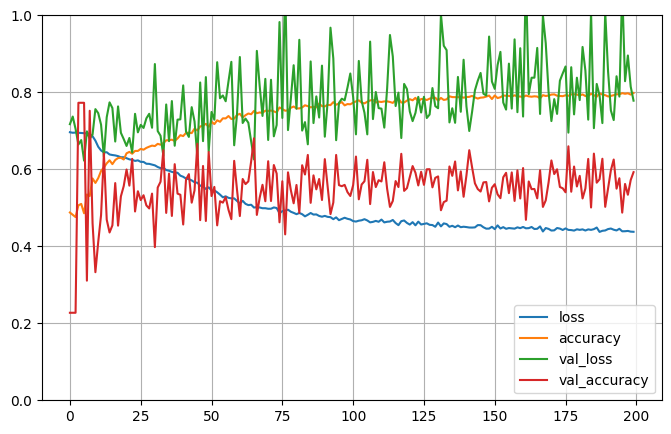


2023-03-29 23:24:30.325000

Testing # 1 5
2023-03-29 23:24:30.325085
2023-03-29 23:24:30.325125
PREDICT
2023-03-29 23:24:30.356151
Test 1:0 921:3131 22.73%
Predict 1:0 1314:2738 32.43%
Test sizes (4052, 1025) (4052,)
Range of scores: 0.00034725558 to 0.99975413
Score threshold 0.5
Confusion matrix
 [[2109 1022]
 [ 629  292]]
Normalized matrix
 [[0.52048371 0.25222113]
 [0.15523198 0.07206318]]


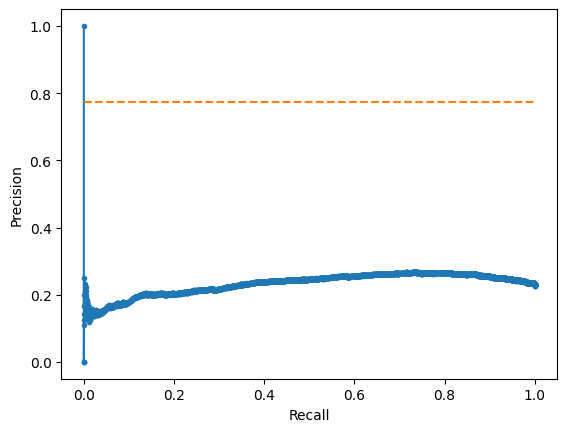

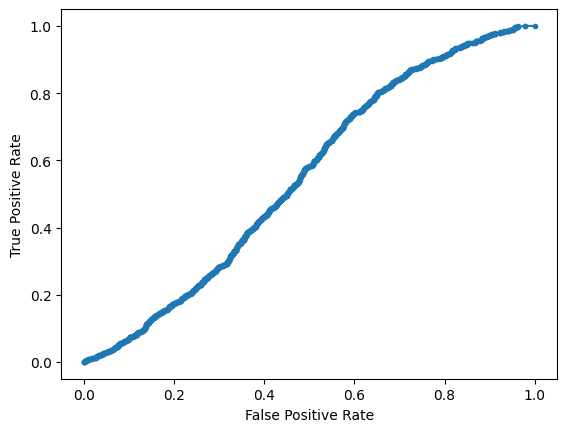

Accuracy: 59.25% Precision: 22.22% Recall: 31.70%
F1: 26.13% MCC: -0.0084
AUPRC: 23.23% AUROC: 55.01%
 accuracy [59.25468904244817]
 precision [22.22222222222222]
 recall [31.704668838219323]
 F1 [26.12975391498881]
 MCC [-0.008385690526945832]
 AUPRC [23.227839977615222]
 AUROC [55.01376553542714]
2023-03-29 23:24:31.310087

Training # 2 1
2023-03-29 23:24:31.310768
2023-03-29 23:24:31.310838
Discriminator is GMM
Means [0.3418890157634187, -1.2097002479565802]
Variances [1.47240949 1.56333281]
Priors [0.59360189 0.40639811]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
Train 1:0 8587:4484 65.70%
Computed class weights: {0: 1.4575156110615521, 1: 0.7610923488994993}
Valid 1:0 2585:1301 66.52%
FIT
2023-03-29 23:24:39.163761


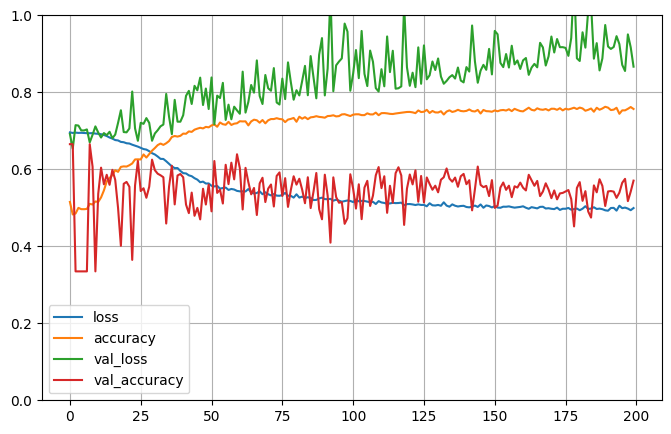


2023-03-29 23:31:03.273513

Testing # 2 1
2023-03-29 23:31:03.275283
2023-03-29 23:31:03.275752
PREDICT
2023-03-29 23:31:03.405991
Test 1:0 2585:1301 66.52%
Predict 1:0 2672:1214 68.76%
Test sizes (3886, 1025) (3886,)
Range of scores: 9.414679e-05 to 0.99998784
Score threshold 0.5
Confusion matrix
 [[ 423  878]
 [ 791 1794]]
Normalized matrix
 [[0.10885229 0.22593927]
 [0.20355121 0.46165723]]


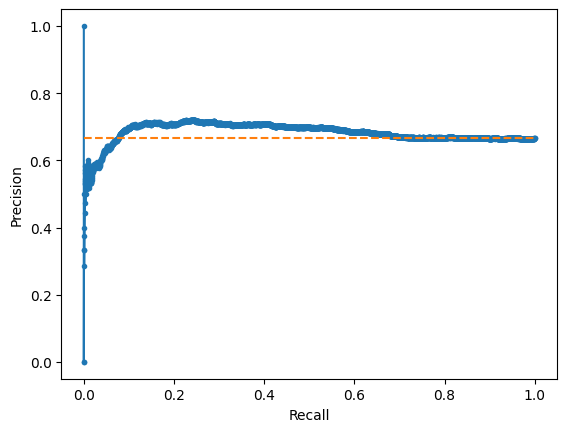

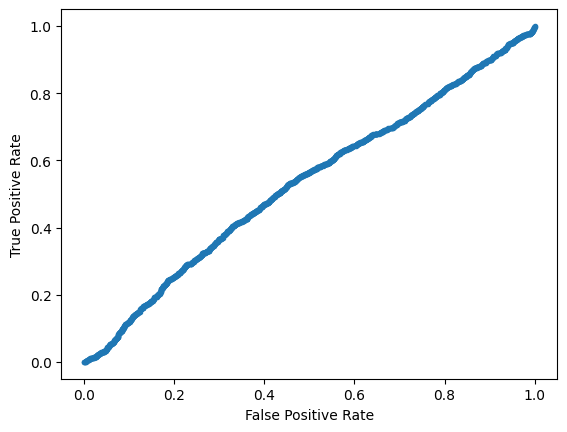

Accuracy: 57.05% Precision: 67.14% Recall: 69.40%
F1: 68.25% MCC: 0.0195
AUPRC: 68.18% AUROC: 53.19%
 accuracy [57.05095213587236]
 precision [67.14071856287424]
 recall [69.40038684719536]
 F1 [68.25185466996386]
 MCC [0.019487069492981058]
 AUPRC [68.18426609989025]
 AUROC [53.19263414394819]
2023-03-29 23:31:05.024745

Training # 2 2
2023-03-29 23:31:05.026846
2023-03-29 23:31:05.027297
Discriminator is GMM
Means [-0.8786246709789869, 0.42340399968189146]
Variances [1.41039343 1.51528324]
Priors [0.57110786 0.42889214]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
Train 1:0 4705:9007 34.31%
Computed class weights: {0: 0.7611857444210058, 1: 1.457173219978746}
Valid 1:0 1294:1951 39.88%
FIT
2023-03-29 23:31:16.037214


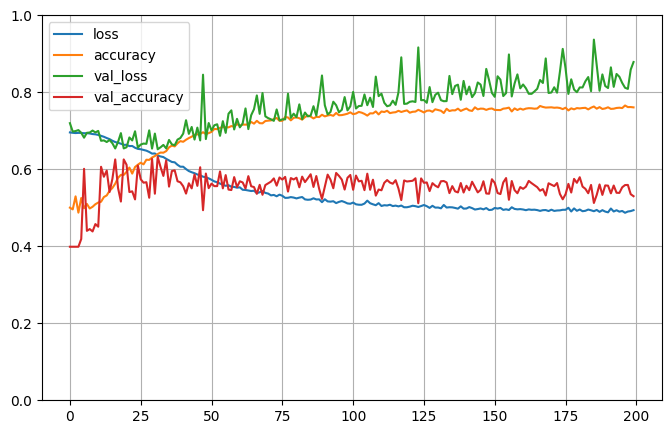


2023-03-29 23:36:49.945194

Testing # 2 2
2023-03-29 23:36:49.945333
2023-03-29 23:36:49.945387
PREDICT
2023-03-29 23:36:49.972583
Test 1:0 1294:1951 39.88%
Predict 1:0 1925:1320 59.32%
Test sizes (3245, 1025) (3245,)
Range of scores: 0.00028473776 to 0.9999965
Score threshold 0.5
Confusion matrix
 [[ 873 1078]
 [ 447  847]]
Normalized matrix
 [[0.26902928 0.33220339]
 [0.13775039 0.26101695]]


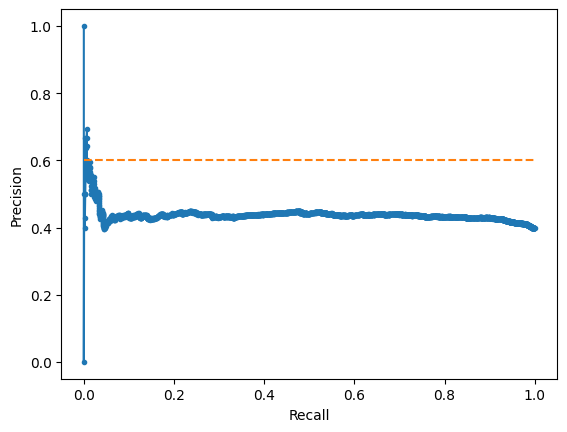

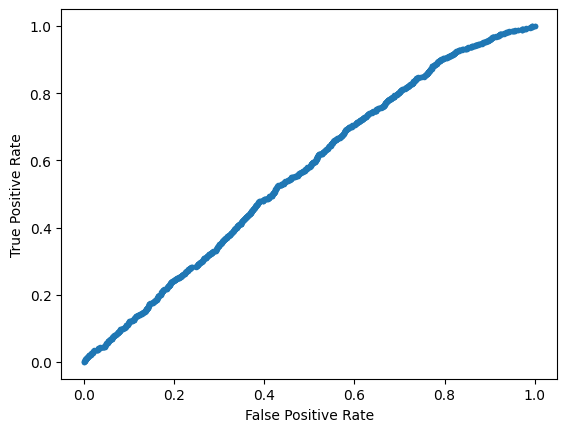

Accuracy: 53.00% Precision: 44.00% Recall: 65.46%
F1: 52.63% MCC: 0.1017
AUPRC: 43.75% AUROC: 56.47%
 accuracy [53.004622496147924]
 precision [44.0]
 recall [65.45595054095827]
 F1 [52.62503883193539]
 MCC [0.10169245732806485]
 AUPRC [43.74932434722243]
 AUROC [56.46941646854899]
2023-03-29 23:36:50.805955

Training # 2 3
2023-03-29 23:36:50.806444
2023-03-29 23:36:50.806511
Discriminator is GMM
Means [-0.7254208368572382, 0.6229227666845941]
Variances [1.44218676 1.60415231]
Priors [0.68522472 0.31477528]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
Train 1:0 2743:10730 20.36%
Computed class weights: {0: 0.6278191985088537, 1: 2.455887714181553}
Valid 1:0 704:2780 20.21%
FIT
2023-03-29 23:37:00.569420


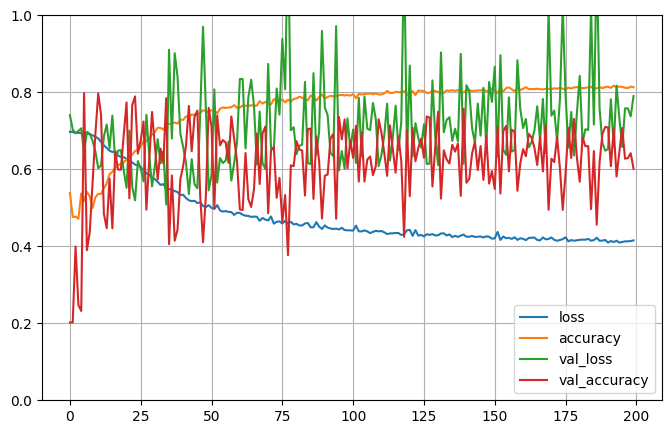


2023-03-29 23:43:24.184027

Testing # 2 3
2023-03-29 23:43:24.185784
2023-03-29 23:43:24.186261
PREDICT
2023-03-29 23:43:24.219681
Test 1:0 704:2780 20.21%
Predict 1:0 1233:2251 35.39%
Test sizes (3484, 1025) (3484,)
Range of scores: 0.0003941824 to 0.9999958
Score threshold 0.5
Confusion matrix
 [[1821  959]
 [ 430  274]]
Normalized matrix
 [[0.52267509 0.27525832]
 [0.12342135 0.07864524]]


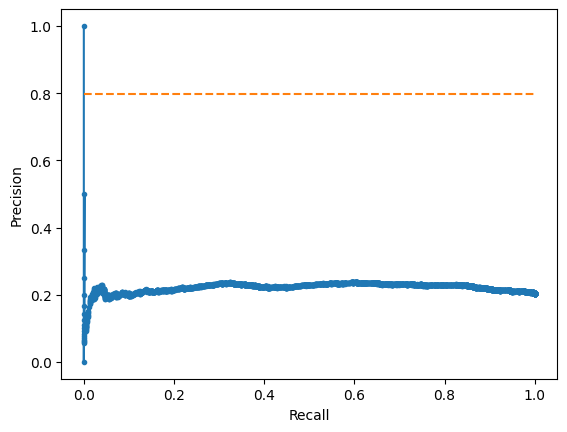

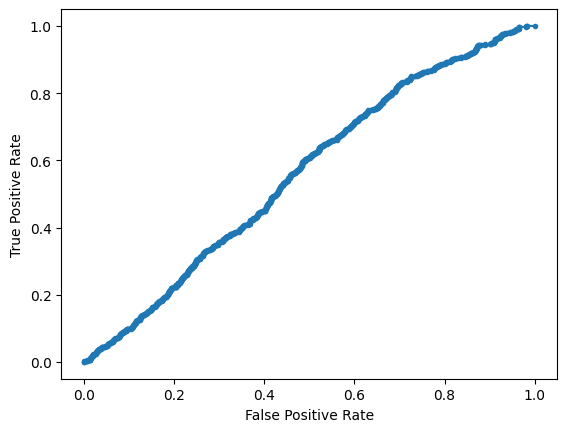

Accuracy: 60.13% Precision: 22.22% Recall: 38.92%
F1: 28.29% MCC: 0.0372
AUPRC: 22.15% AUROC: 56.20%
 accuracy [60.13203214695751]
 precision [22.22222222222222]
 recall [38.92045454545455]
 F1 [28.291171915332985]
 MCC [0.03715006963166439]
 AUPRC [22.147690424833606]
 AUROC [56.19824027141922]
2023-03-29 23:43:25.150081

Training # 2 4
2023-03-29 23:43:25.151461
2023-03-29 23:43:25.151552
Discriminator is GMM
Means [0.3884539784783651, -0.91804912744405]
Variances [1.54583871 1.43130151]
Priors [0.46169889 0.53830111]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
Train 1:0 5821:8111 41.78%
Computed class weights: {0: 0.858833682653187, 1: 1.1967015976636317}
Valid 1:0 1310:1715 43.31%
FIT
2023-03-29 23:43:35.541402


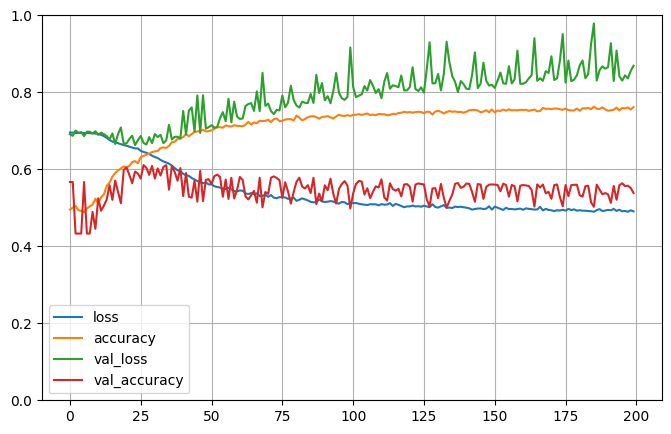


2023-03-29 23:49:05.834919

Testing # 2 4
2023-03-29 23:49:05.835585
2023-03-29 23:49:05.835639
PREDICT
2023-03-29 23:49:05.869308
Test 1:0 1310:1715 43.31%
Predict 1:0 1719:1306 56.83%
Test sizes (3025, 1025) (3025,)
Range of scores: 0.005372986 to 0.99955726
Score threshold 0.5
Confusion matrix
 [[812 903]
 [494 816]]
Normalized matrix
 [[0.26842975 0.2985124 ]
 [0.16330579 0.26975207]]


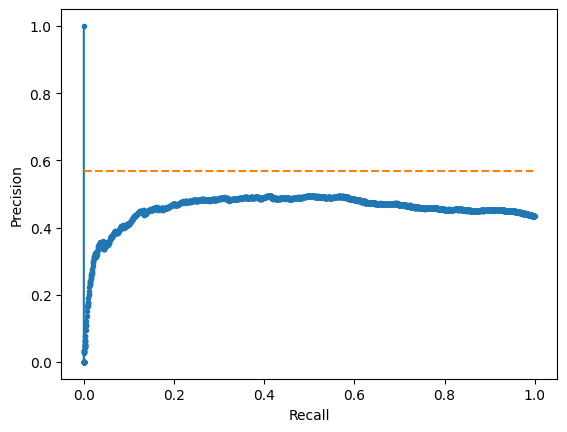

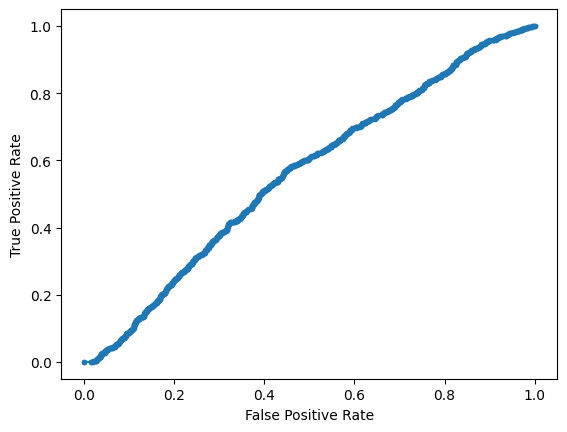

Accuracy: 53.82% Precision: 47.47% Recall: 62.29%
F1: 53.88% MCC: 0.0964
AUPRC: 45.55% AUROC: 55.94%
 accuracy [53.81818181818182]
 precision [47.4694589877836]
 recall [62.29007633587786]
 F1 [53.879168042258165]
 MCC [0.09640525843496277]
 AUPRC [45.55436632193068]
 AUROC [55.93715086907173]
2023-03-29 23:49:06.808011

Training # 2 5
2023-03-29 23:49:06.810693
2023-03-29 23:49:06.811189
Discriminator is GMM
Means [-1.0949500292902934, 0.34354406824539724]
Variances [1.51180964 1.29152659]
Priors [0.46011592 0.53988408]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
Train 1:0 7877:5763 57.75%
Computed class weights: {0: 1.1834114176644108, 1: 0.865811857306081}
Valid 1:0 1998:1319 60.24%
FIT
2023-03-29 23:49:19.500284


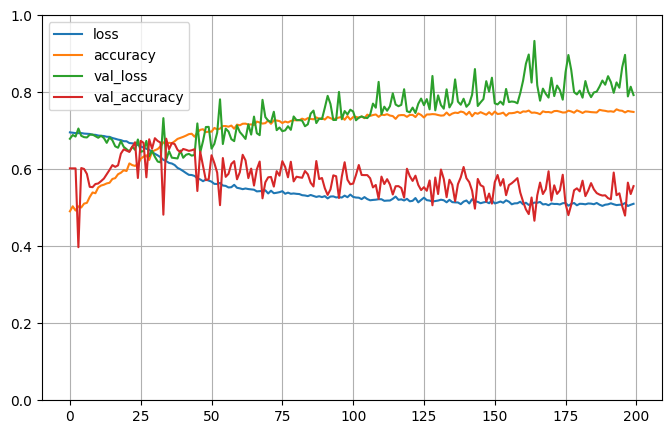


2023-03-29 23:54:51.711146

Testing # 2 5
2023-03-29 23:54:51.711552
2023-03-29 23:54:51.711609
PREDICT
2023-03-29 23:54:51.735076
Test 1:0 1998:1319 60.24%
Predict 1:0 1978:1339 59.63%
Test sizes (3317, 1025) (3317,)
Range of scores: 0.008311097 to 0.9999392
Score threshold 0.5
Confusion matrix
 [[ 593  726]
 [ 746 1252]]
Normalized matrix
 [[0.178776   0.21887248]
 [0.22490202 0.3774495 ]]


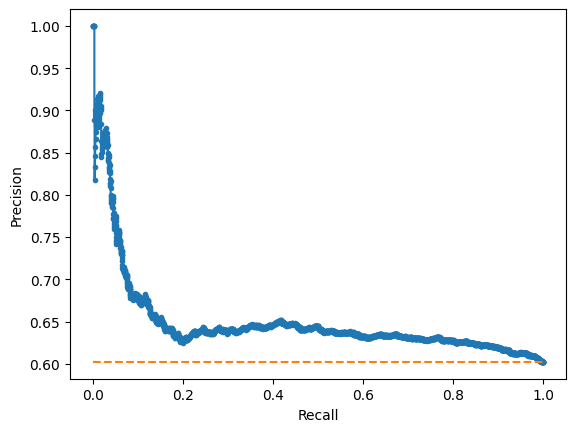

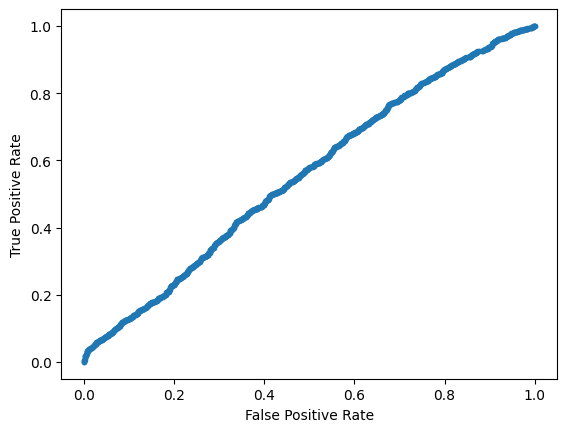

Accuracy: 55.62% Precision: 63.30% Recall: 62.66%
F1: 62.98% MCC: 0.0760
AUPRC: 64.96% AUROC: 55.55%
 accuracy [55.62255049743744]
 precision [63.29625884732053]
 recall [62.66266266266266]
 F1 [62.97786720321932]
 MCC [0.07601978567482447]
 AUPRC [64.96403615226984]
 AUROC [55.55170409226513]
2023-03-29 23:54:52.631662


In [39]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_spectra(filepath)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_spectra(filepath)
    print('Loaded',len(test_allseq),'sequences.')

REPEATS = 2
FOLDS = 5
for repeat in range(REPEATS):
    for fold in range(FOLDS):
        r = repeat+1
        f = fold+1

        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,r,f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            test_allids = None
            test_allseq = None
            test_gene_to_rci = None
            
        print(datetime.now())
        print()
        print("Training #",r,f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS,BREAK)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        cvdo.train_new_model(
            train_allids,train_allseq,train_gene_to_rci,
            test_allids,test_allseq,test_gene_to_rci)
           
        print()
        print(datetime.now())
        print()
        print("Testing #",r,f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [40]:
def STD (values):
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.2f%% std %.2f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 53.55% std 4.51
 precision mean 52.46% std 18.25
 recall mean 48.19% std 15.48
 F1 mean 48.11% std 13.89
 MCC mean 0.05% std 0.05
 AUPRC mean 52.28% std 18.14
 AUROC mean 54.78% std 3.31
 accuracy [[48.21867321867322], [46.66078258311268], [51.06100795755968], [50.71119356833642], [59.25468904244817], [57.05095213587236], [53.004622496147924], [60.13203214695751], [53.81818181818182], [55.62255049743744]]
 precision [[61.989978525411594], [55.6809024979855], [71.64518574677786], [68.88586956521739], [22.22222222222222], [67.14071856287424], [44.0], [22.22222222222222], [47.4694589877836], [63.29625884732053]]
 recall [[42.850074220682835], [35.36335721596725], [46.16511968734734], [27.083333333333332], [31.704668838219323], [69.40038684719536], [65.45595054095827], [38.92045454545455], [62.29007633587786], [62.66266266266266]]
 F1 [[50.672908133411354], [43.255086071987485], [56.14973262032086], [38.88036809815951], [26.12975391498881], [68.25185466996386], [52.625038831